# Tow-Based Discontinuous Composite (TBDC) property predictor
This code is written for an MSc research project at Imperial College London

## Mount drive

In [1]:
# Data to be imported from google drive
from google.colab import drive
drive.mount('/content/drive')

# Set path for drive with datasets
drive_path ="/content/drive/MyDrive/Individual_project_ICL"

Mounted at /content/drive


## Imports and installs

In [2]:
import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


In [33]:
import os
import random
import time
import math
import datetime
import shutil
import json
import scipy
from sklearn import preprocessing
import sklearn
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# # for creating a responsive plot
# from google.colab import output
# output.enable_custom_widget_manager()
# # %matplotlib widget
# %matplotlib notebook


## Import data


In [4]:
if 'data' not in os.listdir():
  !cp {drive_path+"/Data/Unnotched_TBDC_2022.zip"} .
  !unzip -q 'Unnotched_TBDC_2022.zip' -d data
  !rm 'Unnotched_TBDC_2022.zip'

In [5]:
def loadSample(path = str):
  '''
  Imports data in csv and formats into a tensor
  '''
  # Read sample csv data
  sample = pd.read_csv(path)
  headers = sample.columns.values.tolist()
  values = np.array(sample)

  coords = [[x for x in values[:,1][y].split(' ') if x] for y in range(len(values[:,1]))] # Split coordinates by delimiter (space)
  coords = [np.char.strip(x, '[') for x in coords] # Coordinate output from abaqus has leading "["
  coords = [[x for x in coords[y] if x] for y in range(len(values[:,1]))] # remove empty array elements
  coords = np.array([[float(x) for x in coords[y][0:2]] for y in range(len(values[:,1]))]) # Take 2d coordinates and convert to float


  values = np.column_stack((values[:,0],coords,values[:,2:])).astype(float) # Create a new values vector which contains the coordinates
  # values = values.astype(np.float)

  headers = np.concatenate(([[headers[0],'x_coord','y_coord'],headers[2:]])) # rectify the headers to include x and y coordinates separately

  return headers, values




# Verify Data Import

['label' 'x_coord' 'y_coord' 'e11' 'e22' 'e12' 'S11' 'S22' 'S12' 'SMises'
 'FI' 'E11' 'E22' 'E12']
[[ 1.00000000e+00  2.37500000e+01  6.77454500e+01 ...  4.23866914e+04
   4.32930625e+04  2.06601074e+04]
 [ 2.00000000e+00  2.12500000e+01  6.77454500e+01 ...  4.19203984e+04
   4.16220039e+04  2.13048340e+04]
 [ 3.00000000e+00  1.87500000e+01  6.77454500e+01 ...  4.14541055e+04
   3.99509414e+04  2.19495605e+04]
 ...
 [ 1.09800000e+03 -1.87500000e+01 -6.77454500e+01 ...  5.58986875e+04
   4.46753555e+04  1.70089414e+04]
 [ 1.09900000e+03 -2.12500000e+01 -6.77454500e+01 ...  5.65772109e+04
   4.28433398e+04  1.74488691e+04]
 [ 1.10000000e+03 -2.37500000e+01 -6.77454500e+01 ...  5.72557305e+04
   4.10113242e+04  1.78887988e+04]]


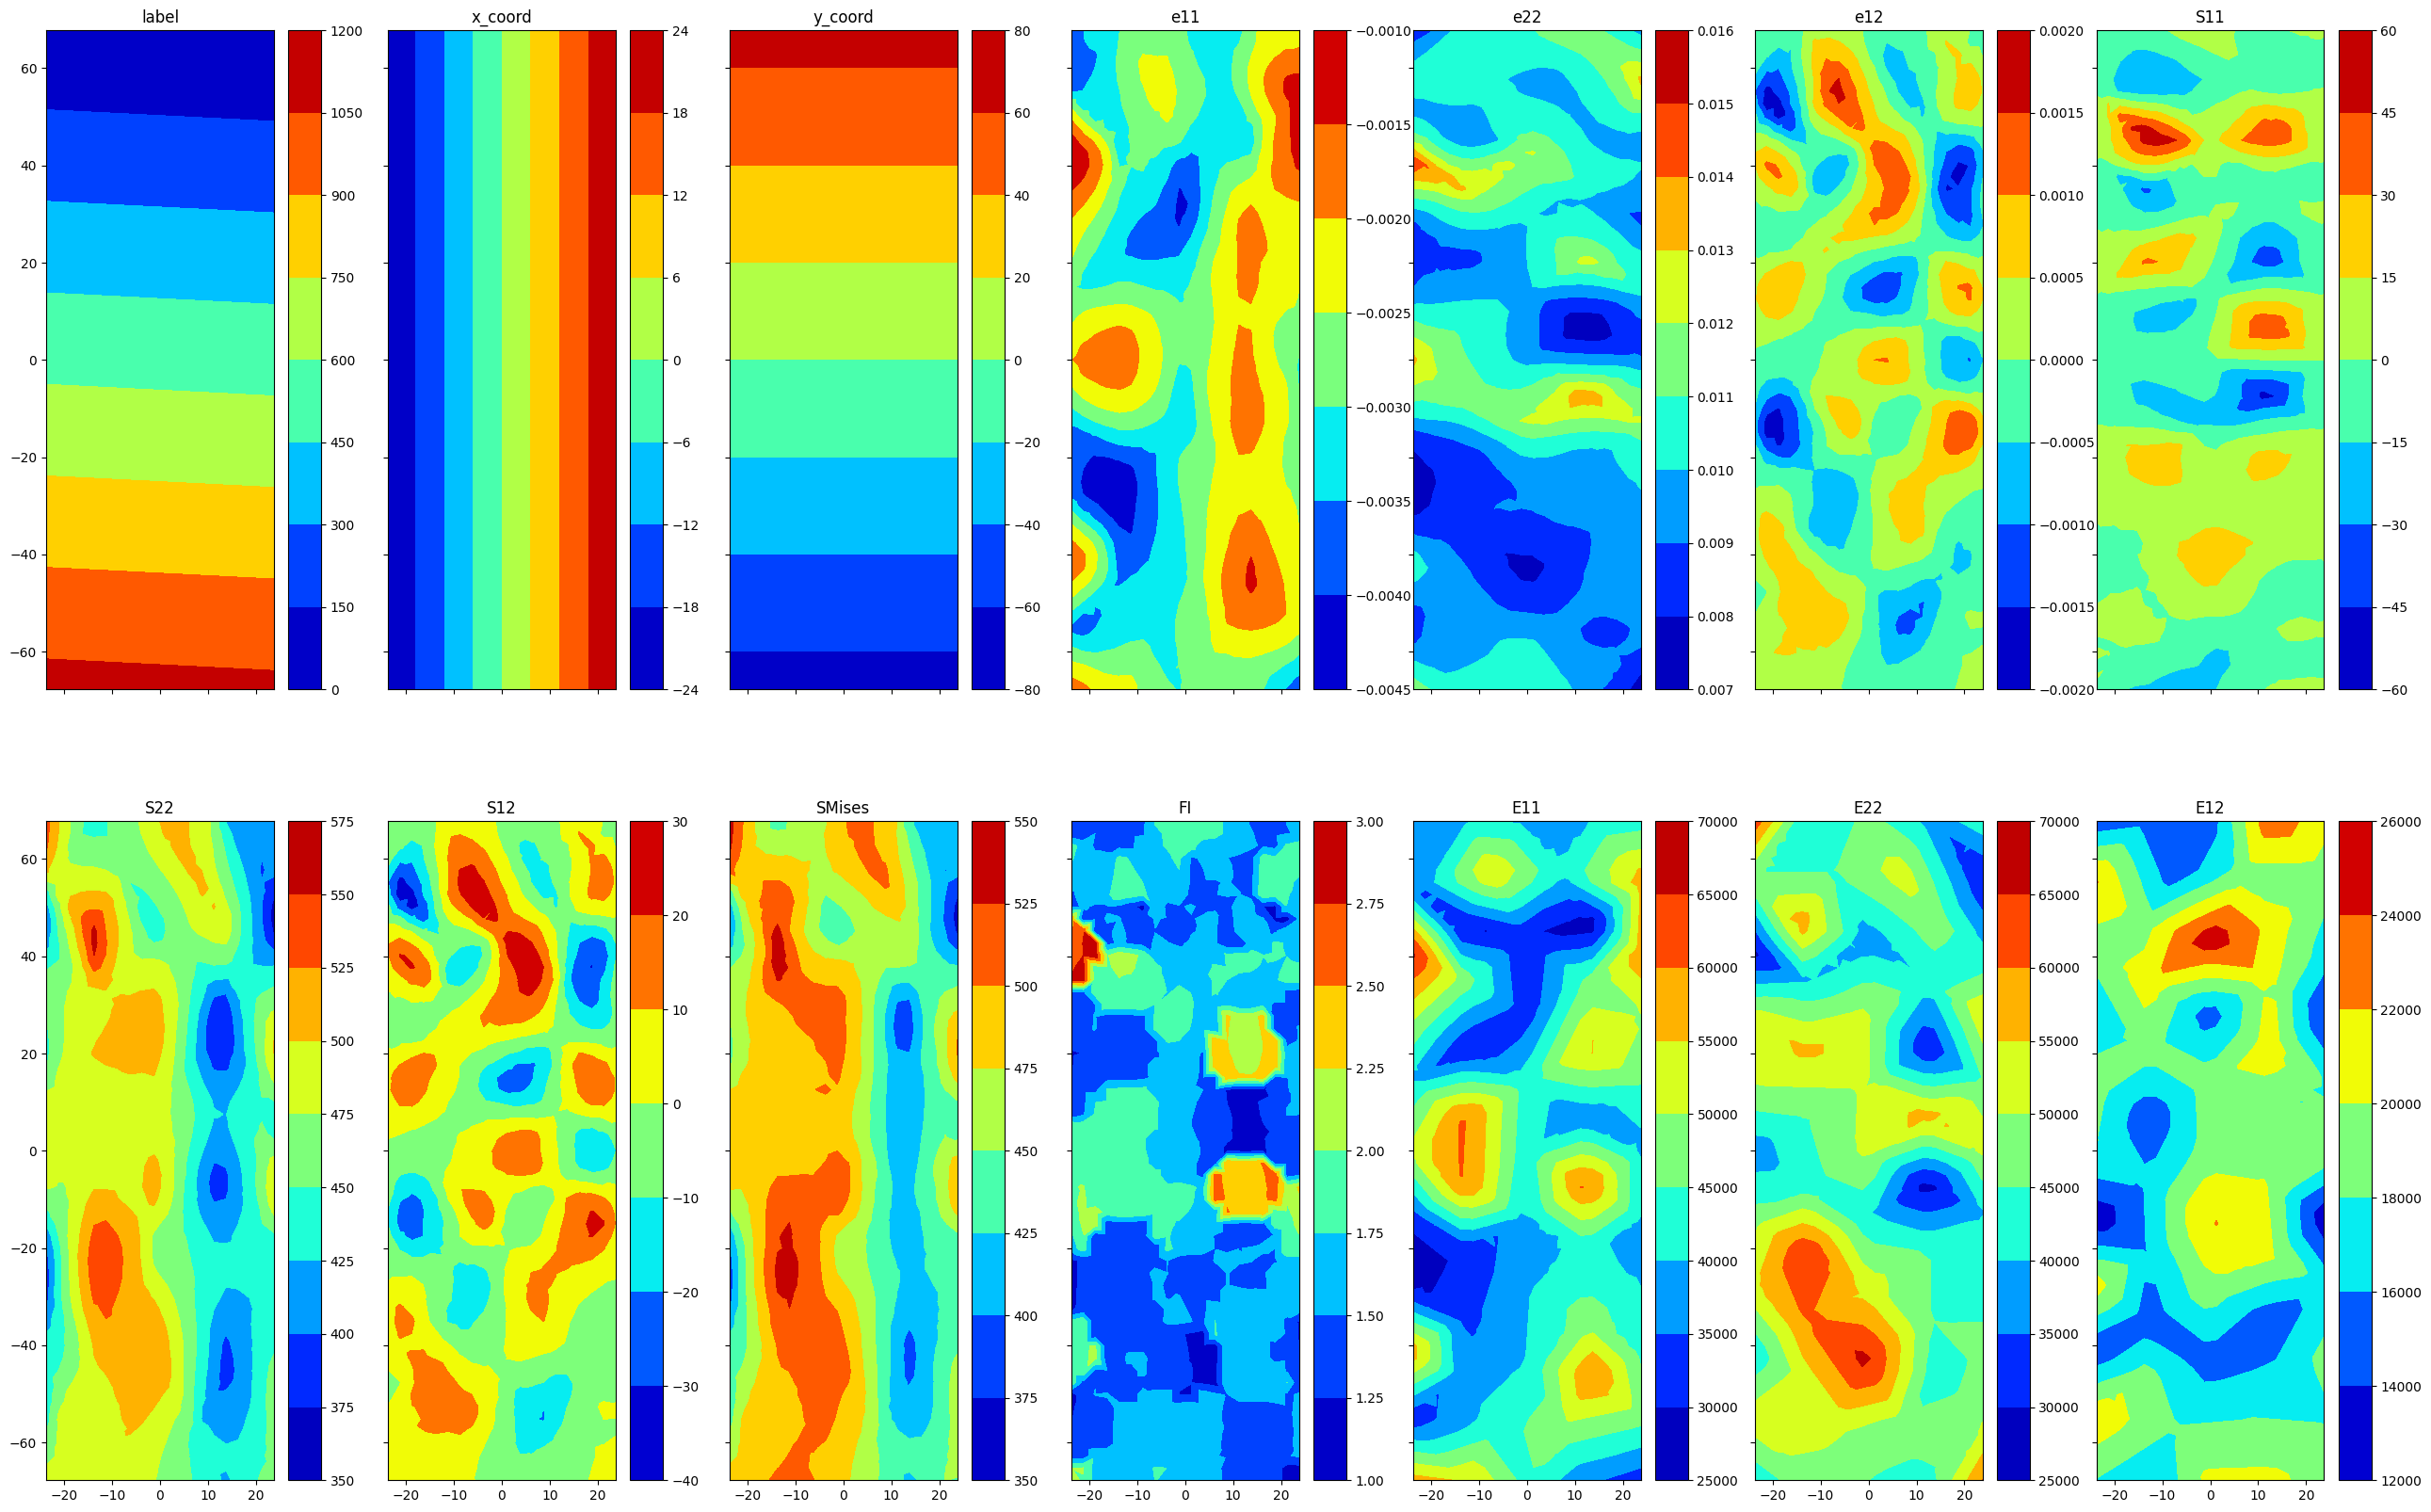

In [6]:
testHeaders, testSample = loadSample('data/Unnotched_TBDC_2022_0.csv')
print(testHeaders)
print(testSample)
import matplotlib.tri as tri
import matplotlib.ticker as plticker

fig, axs = plt.subplots(2, int(len(testHeaders)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(testSample[:,1], testSample[:,2])
min_radius = 0.25
# Mask off unwanted triangles.
triang.set_mask(np.hypot(testSample[:,1][triang.triangles].mean(axis=1), testSample[:,2][triang.triangles].mean(axis=1)) < min_radius)

# Plot triangulation map
for i in range(len(testHeaders)):
  ax = plt.subplot(2, int(len(testHeaders)/2), i+1)
  tcf = ax.tricontourf(triang, testSample[:,i], cmap = 'jet')
  fig.colorbar(tcf)
  ax.set_title(testHeaders[i])


Alternative method without triangulation but reshaping into 2d matrix

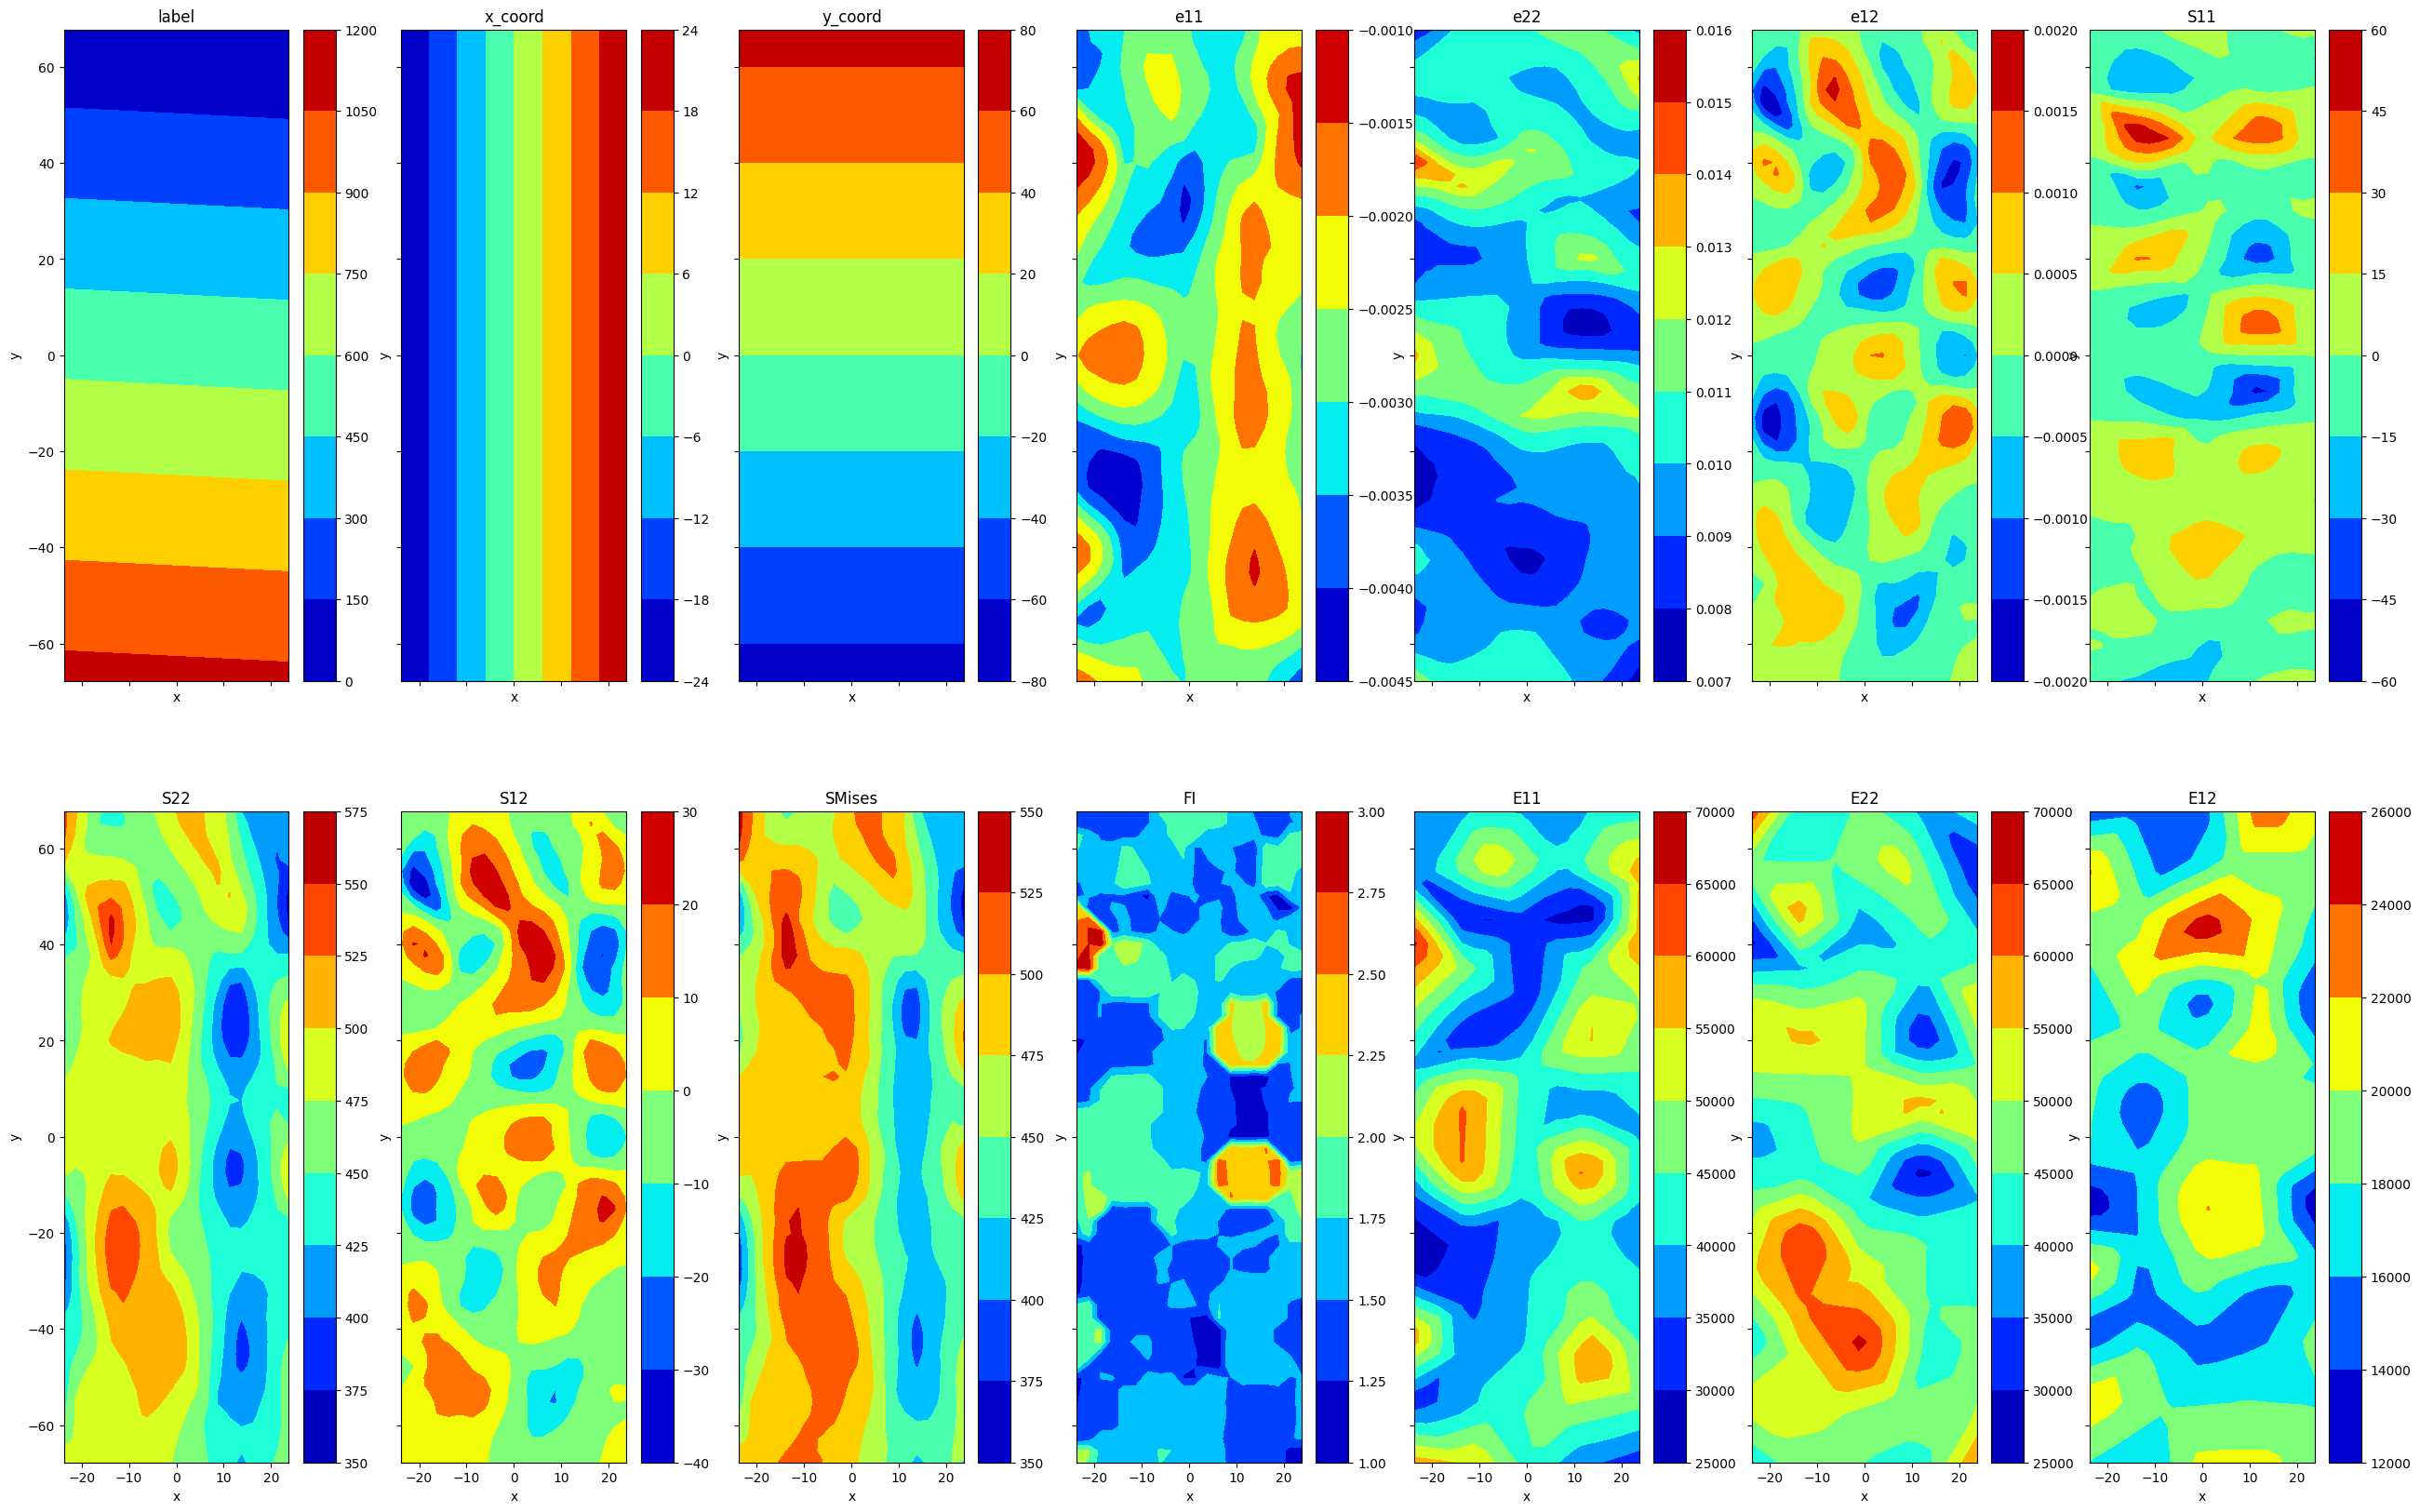

In [7]:
# Shape of specimen is 20x55
testReshaped = testSample.reshape(55,20,14)

fig, axs = plt.subplots(2, int(len(testHeaders)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables

# Plot  map
for i in range(len(testHeaders)):
  ax = plt.subplot(2, int(len(testHeaders)/2), i+1)
  CS = ax.contourf(testReshaped[:,:,1],testReshaped[:,:,2],testReshaped[:,:,i], cmap = 'jet')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(testHeaders[i])
  fig.colorbar(CS)

# Input pipeline functions

In [10]:
def normalise(input_matrix) -> tuple:
    '''
    Normalise values in matrix to lie between 0 and 1

    Args
    ----------
    input_matrix : np.array
        Numpy array of data in shape [55,20,14]
        OR
        Numpy array of data in shape [1100,14] if not reshaped
        There are 11 features which are each normalised, features 1, 2, and 3 are labels and x/y coordinates

    Returns
    ----------
    tuple
        Normalised array
    '''

    # min_max_scaler = preprocessing.StandardScaler()
    for i in range(3, 14):
      if len(np.shape(input_matrix)) == 3:
        input_matrix[:,:,i] = preprocessing.scale(input_matrix[:,:,i], axis=0, copy=True)
      elif len(np.shape(input_matrix)) == 2:
        input_matrix[:,i] = preprocessing.scale(input_matrix[:,i], axis=0, copy=True)
      else:
        raise Exception("Data to be normalised not of correct shape")



    return input_matrix

In [152]:
def show_prediction(sample, prediction, ground_truth, grid):
  '''
  For a given dataset plots one image, its true mask, and predicted mask

  Args
  ----------
  sample: the 55x20x3 input
  prediction: the predicted field
  ground_truth: the ground truth field

  Returns
  ----------
  Nothing, graph will be displayed

  '''
  # Plot  inputs

  fig, axs = plt.subplots(1, sample.shape[-1],figsize=[10,5]) # Create subplots to fit input fields
  for i in range(sample.shape[-1]):
    ax = plt.subplot(1, sample.shape[-1], i+1)
    CS = ax.contourf(grid[0],grid[1],sample[:,:,i], cmap = 'jet')
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.title(testHeaders[i])
    fig.colorbar(CS)
    plt.title('input'+str(i+1))

  # Plot outputs
  fig, axs = plt.subplots(1, 2,figsize=[10, 5]) # Create subplots to fit output fields

  ax = plt.subplot(1, 2, 1)
  CS = ax.contourf(grid[0],grid[1],ground_truth, cmap = 'jet')
  plt.xlabel('x')
  plt.ylabel('y')
  fig.colorbar(CS)
  plt.title('ground truth')

  ax = plt.subplot(1, 2, 2)
  CS = ax.contourf(grid[0],grid[1],prediction, cmap = 'jet')
  plt.xlabel('x')
  plt.ylabel('y')
  fig.colorbar(CS)
  plt.title('prediction')


# Data preprocessing

In [36]:
# Import all data samples
numSamples = 100

for i in range(numSamples):
  path = 'data/Unnotched_TBDC_2022_'+str(i)+'.csv'
  if i==0:
    headers, samples = loadSample(path)
    samples = samples.reshape(1, np.shape(samples)[0],np.shape(samples)[1])
  else:
    addSamp = loadSample(path)[1]
    samples = np.concatenate((samples,addSamp.reshape(1, np.shape(addSamp)[0],np.shape(addSamp)[1])))

samples = normalise(samples)
# Reshape sample variable to have shape (samples, row, column, features)
samples2D = samples.reshape(np.shape(samples)[0],55,20,14)
print(np.shape(samples))
print(np.shape(samples2D))



(100, 1100, 14)
(100, 55, 20, 14)


In [9]:
# # Test that import and reshape is correct
# fig, axs = plt.subplots(2, int(len(headers)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables
# sampleNum = 0
# # Plot  map
# for i in range(len(headers)):
#   ax = plt.subplot(2, int(len(headers)/2), i+1)
#   CS = ax.contourf(samples2D[sampleNum,:,:,1],samples2D[sampleNum,:,:,2],samples2D[sampleNum,:,:,i], cmap = 'jet')
#   plt.xlabel('x')
#   plt.ylabel('y')
#   plt.title(headers[i])
#   fig.colorbar(CS)

# Computing correlation stats

Test normalisation function

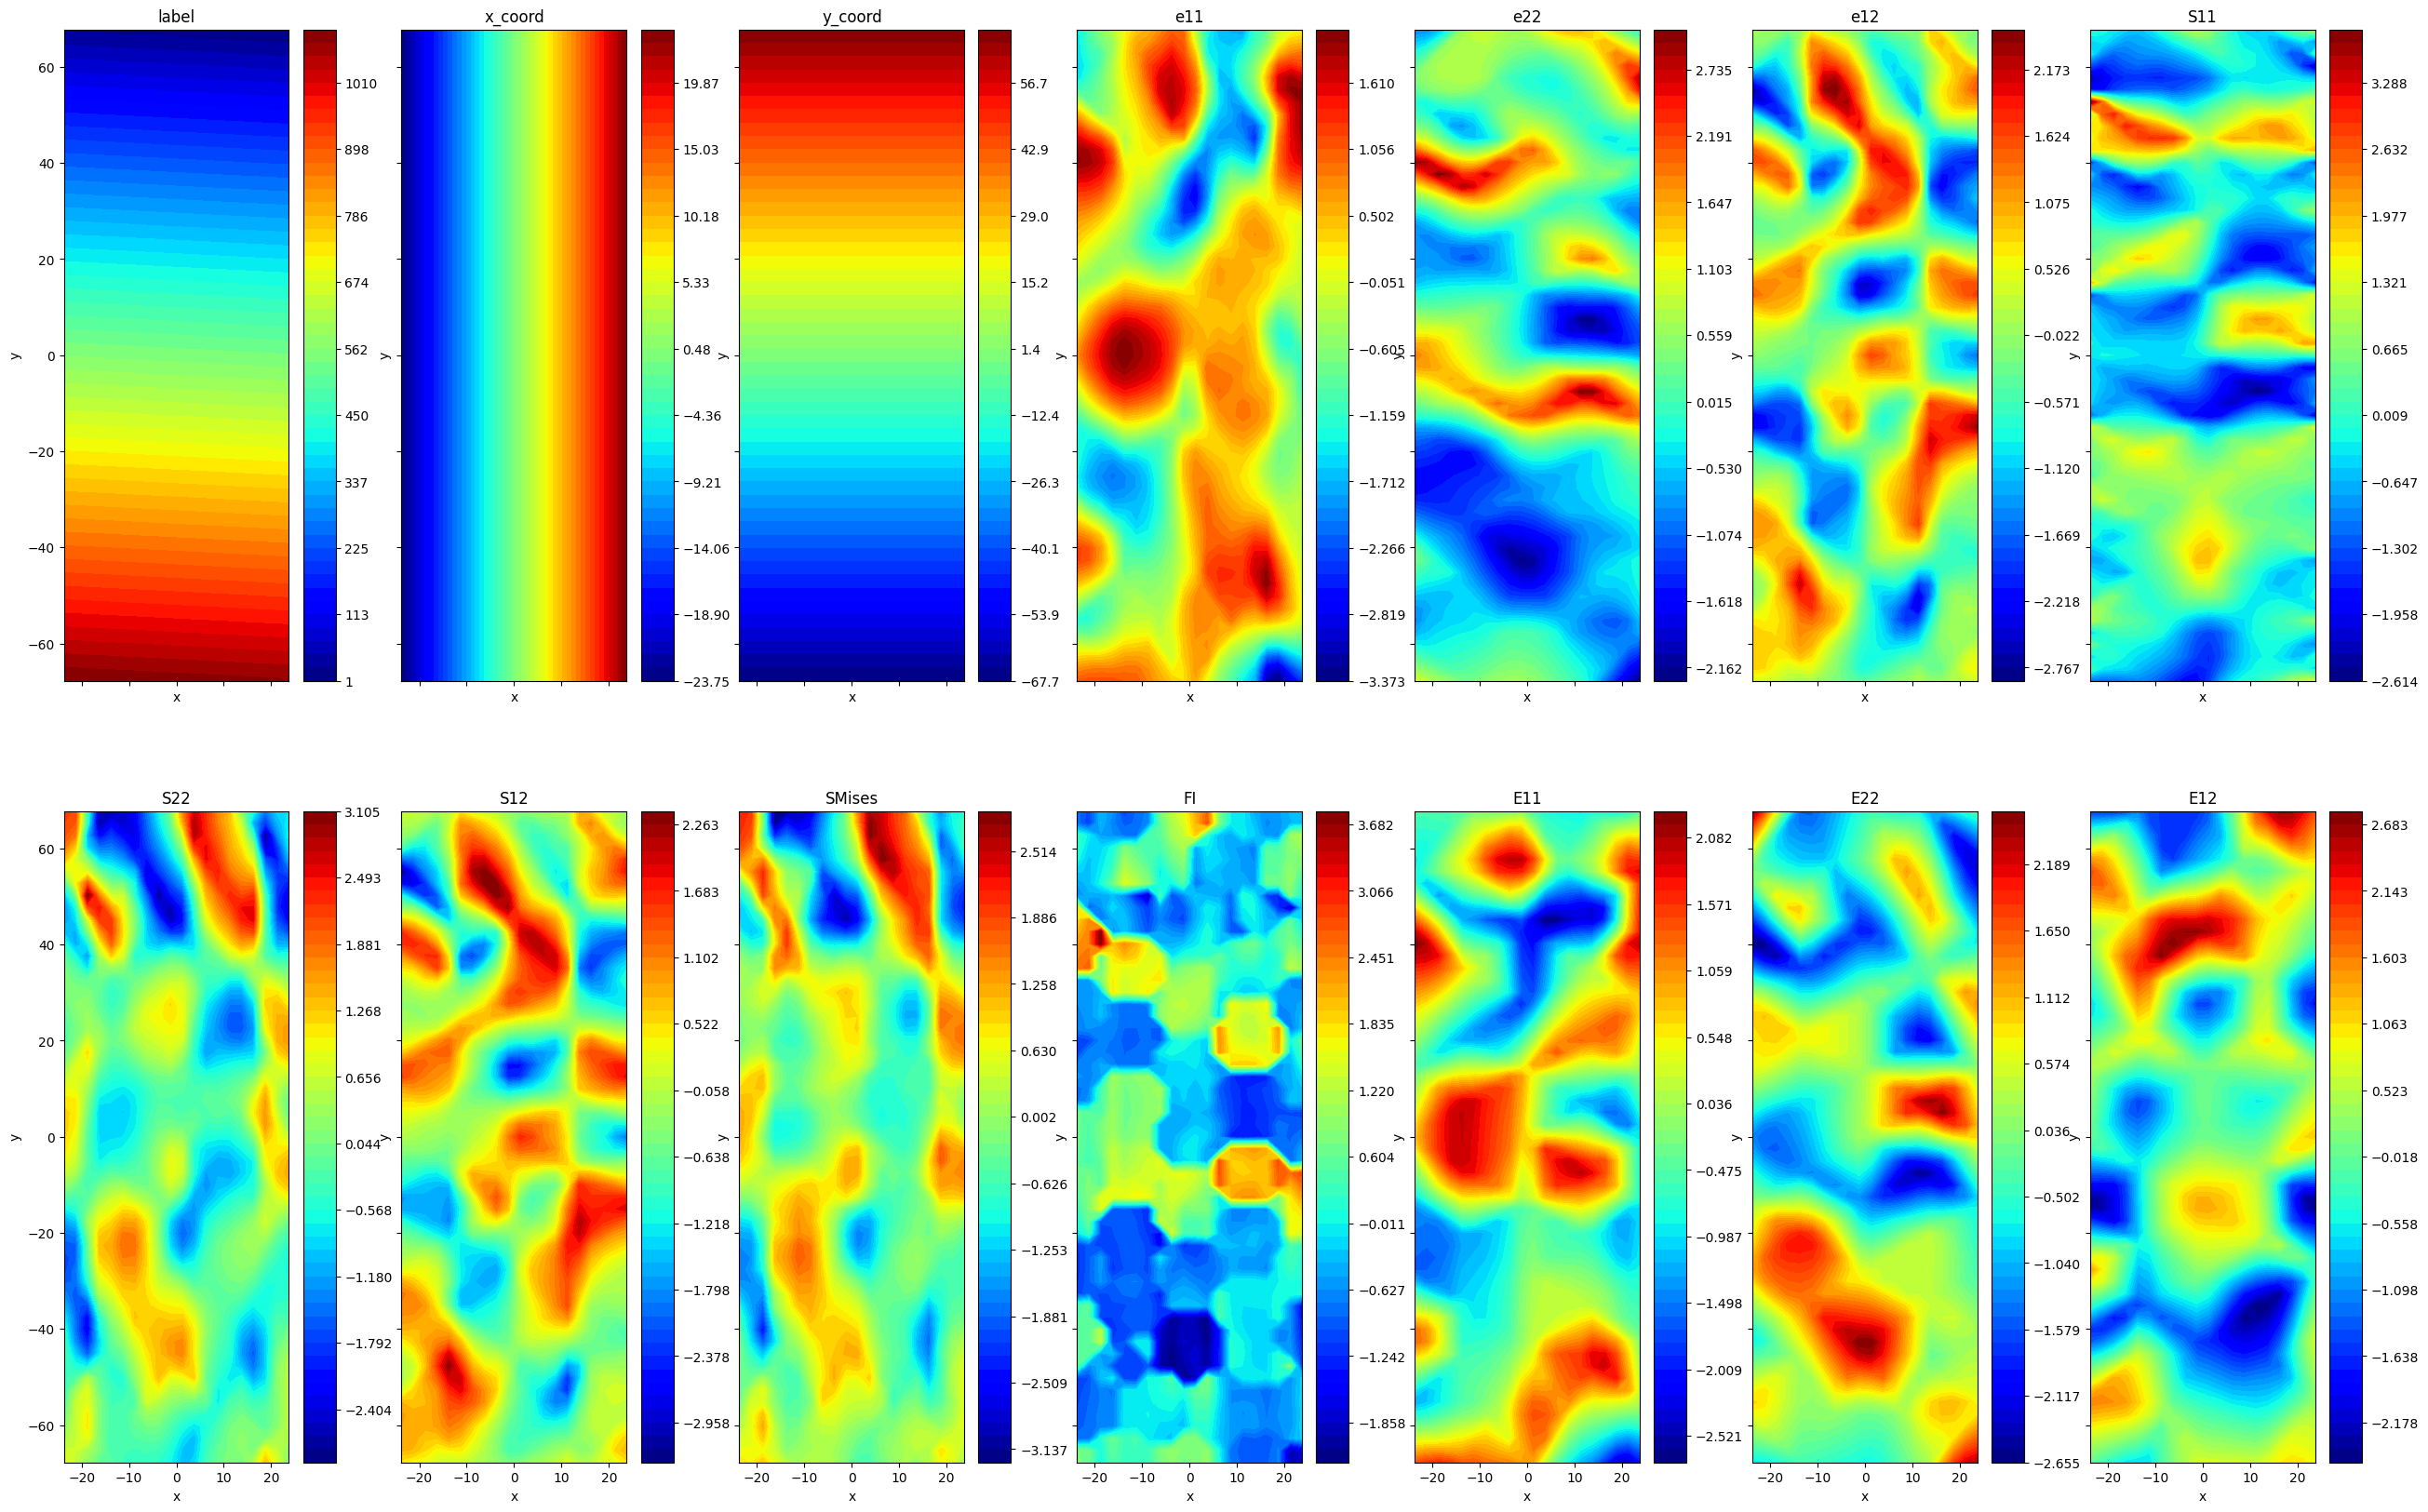

In [11]:
normalisedTest = normalise(testReshaped)

fig, axs = plt.subplots(2, int(len(testHeaders)/2), sharex=True, sharey=True,figsize=[32,20]) # Create subplots to fit all variables

# Plot  map
for i in range(len(testHeaders)):
  ax = plt.subplot(2, int(len(testHeaders)/2), i+1)
  CS = ax.contourf(normalisedTest[:,:,1],normalisedTest[:,:,2],normalisedTest[:,:,i],levels = np.linspace(np.min(normalisedTest[:,:,i]),np.max(normalisedTest[:,:,i]),50), cmap = 'jet')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(testHeaders[i])
  fig.colorbar(CS)

Text(0, 0.5, 'e22')

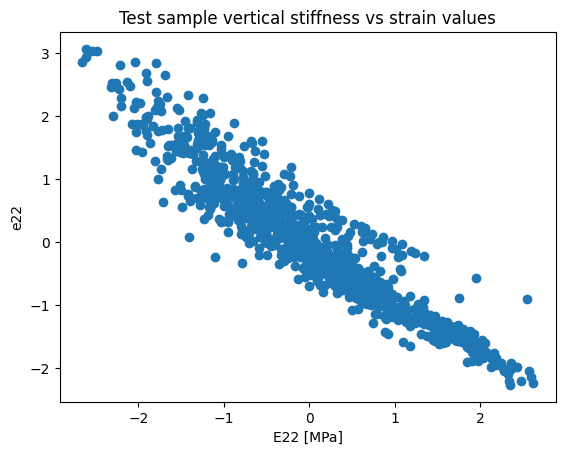

In [25]:
fig, axs = plt.subplots()
plt.scatter(E22,e22)
plt.title('Test sample vertical stiffness vs strain values')
plt.xlabel('E22 [MPa]')
plt.ylabel('e22')
fig, axs = plt.subplots()
plt.scatter(E22,FI)
plt.title('Test sample vertical stiffness vs failure index values')
plt.xlabel('E22 [MPa]')
plt.ylabel('FI')

In [27]:
# Normalise data and calculate correlation coefficients to stiffness components

# Reminder: the header index is the following
# [   0        1         2       3     4     5     6     7     8      9      10   11    12    13  ]
# ['label' 'x_coord' 'y_coord' 'e11' 'e22' 'e12' 'S11' 'S22' 'S12' 'SMises' 'FI' 'E11' 'E22' 'E12']

featureIdxs = range(3,14)

# Pearson correlation coefficient describing linear correlation
pearsonCorrE11 = np.zeros((numSamples,len(featureIdxs))) # Pearson correlation with E11 (Horizontal stiffness)
pearsonCorrE11Pval = np.copy(pearsonCorrE11)
pearsonCorrE22 = np.zeros((numSamples,len(featureIdxs))) # Pearson correlation with E22 (vertical stiffness)
pearsonCorrE22Pval = np.copy(pearsonCorrE22)
pearsonCorrE12 = np.zeros((numSamples,len(featureIdxs))) # Pearson correlation with E12 (shear)
pearsonCorrE12Pval = np.copy(pearsonCorrE12)
pearsonCorrFI = np.zeros((numSamples,len(featureIdxs))) # Pearson correlation with Failure index
pearsonCorrFIPval = np.copy(pearsonCorrFI)

# Spearman's correlation coefficient is the correlation of rank (i.e. if features monotonically increase together independent of proportionality)
spearmanCorrE11 = np.zeros((numSamples, len(featureIdxs))) # Spearman's correlation with E11 (Horizontal stiffness)
spearmanCorrE11Pval = np.copy(spearmanCorrE11)
spearmanCorrE22 = np.zeros((numSamples, len(featureIdxs))) # Spearman's correlation with E22 (vertical stiffness)
spearmanCorrE22Pval = np.copy(spearmanCorrE22)
spearmanCorrE12 = np.zeros((numSamples, len(featureIdxs))) # Spearman's correlation with E12 (shear)
spearmanCorrE12Pval = np.copy(spearmanCorrE12)
spearmanCorrFI = np.zeros((numSamples, len(featureIdxs))) # Spearman's correlation with Failure index
spearmanCorrFIPval = np.copy(spearmanCorrFI)



for i in range(numSamples):
  samples[i] = normalise(samples[i]) # Normalise all features to [0,1] range
  for j, k in enumerate(featureIdxs): # Calculate correlation coefficients
    # E11
    pearsonCorrE11[i,j], pearsonCorrE11Pval[i,j] = scipy.stats.pearsonr(samples[i,:,11],samples[i,:,k])
    spearmanCorrE11[i,j], spearmanCorrE11Pval[i,j] = scipy.stats.spearmanr(samples[i,:,11],samples[i,:,k])

    # E22
    pearsonCorrE22[i,j], pearsonCorrE22Pval[i,j] = scipy.stats.pearsonr(samples[i,:,12],samples[i,:,k])
    spearmanCorrE22[i,j], spearmanCorrE22Pval[i,j] = scipy.stats.spearmanr(samples[i,:,12],samples[i,:,k])

    # E12
    pearsonCorrE12[i,j], pearsonCorrE12Pval[i,j] = scipy.stats.pearsonr(samples[i,:,13],samples[i,:,k])
    spearmanCorrE12[i,j], spearmanCorrE12Pval[i,j] = scipy.stats.spearmanr(samples[i,:,13],samples[i,:,k])

    # FI
    pearsonCorrFI[i,j], pearsonCorrFIPval[i,j] = scipy.stats.pearsonr(samples[i,:,10],samples[i,:,k])
    spearmanCorrFI[i,j], spearmanCorrFIPval[i,j] = scipy.stats.spearmanr(samples[i,:,10],samples[i,:,k])



[Text(0, 0, 'e11'),
 Text(1, 0, 'e22'),
 Text(2, 0, 'e12'),
 Text(3, 0, 'S11'),
 Text(4, 0, 'S22'),
 Text(5, 0, 'S12'),
 Text(6, 0, 'SMises'),
 Text(7, 0, 'FI'),
 Text(8, 0, 'E11'),
 Text(9, 0, 'E22'),
 Text(10, 0, 'E12')]

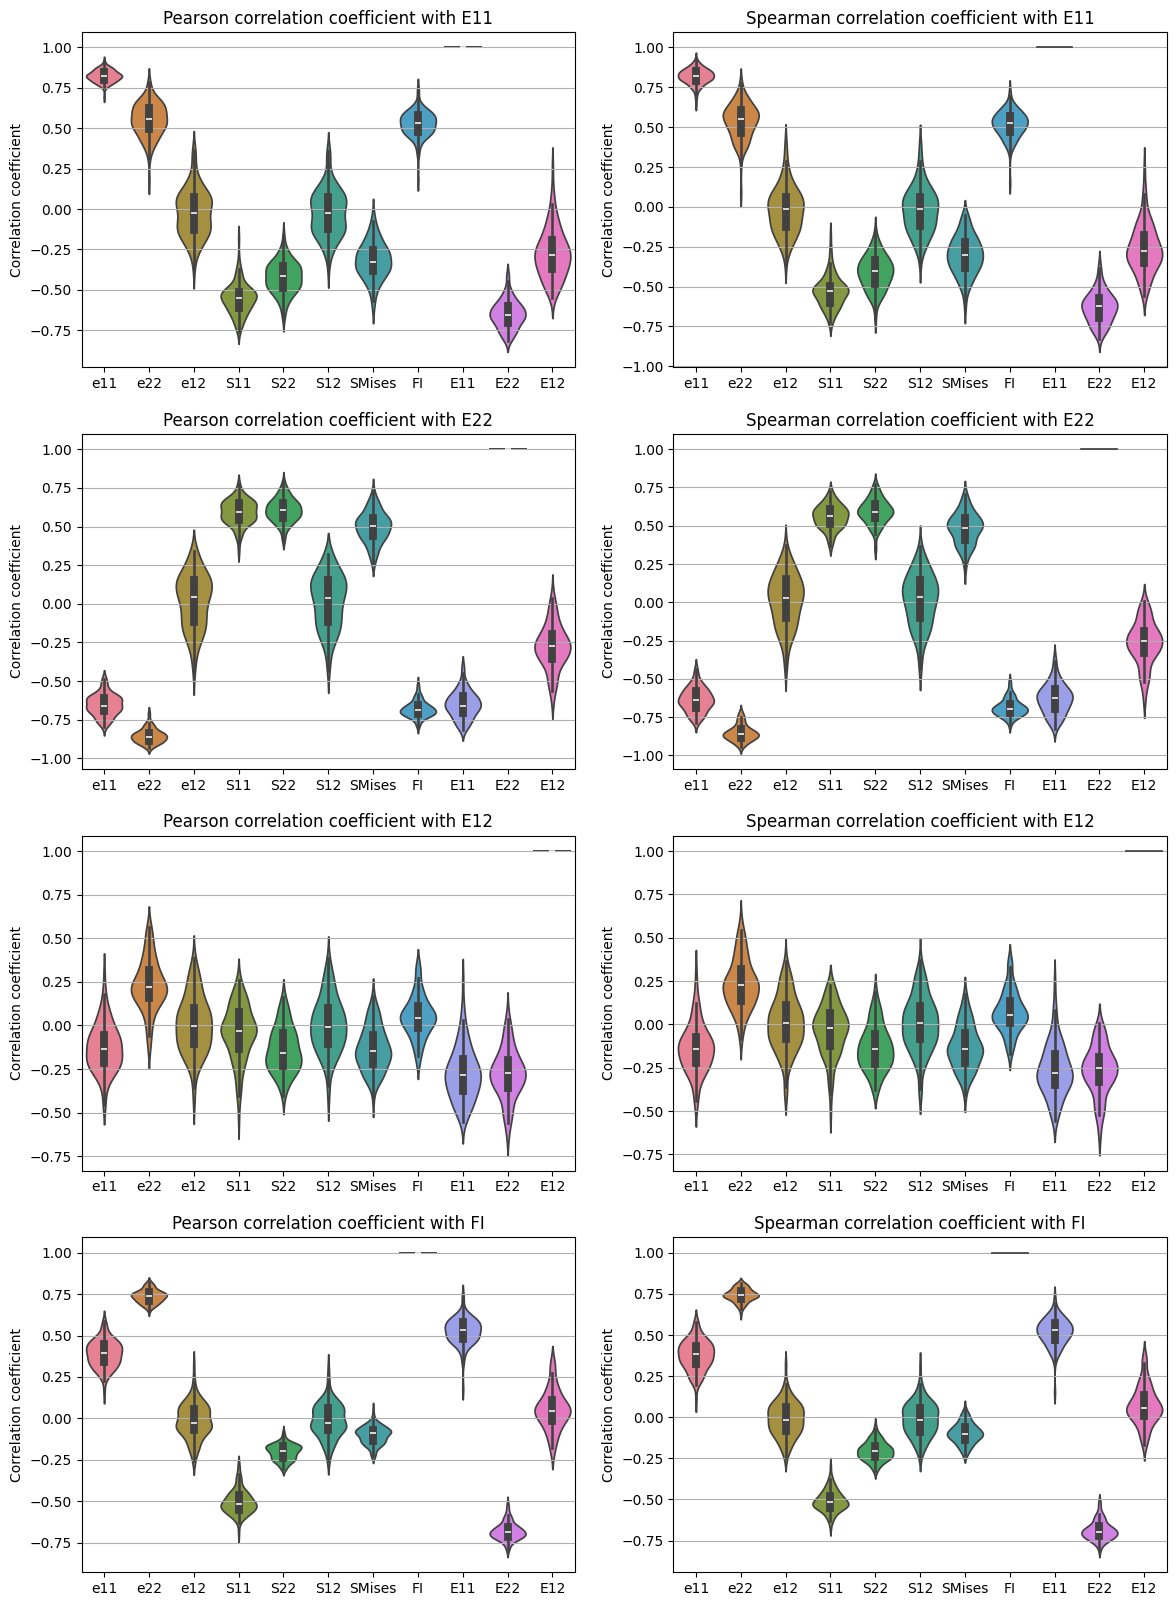

In [30]:
# Plot correlation coefficients
fig, axs = plt.subplots(4, 2, figsize=[14,20]) # Create subplots

# Plot correlation coefficients
axis = plt.subplot(4,2,1)
plt.grid()
g = sns.violinplot(ax=axis, data=pearsonCorrE11)
plt.title('Pearson correlation coefficient with E11')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(pearsonCorrE11[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(4,2,2)
plt.grid()
g = sns.violinplot(ax=axis, data=spearmanCorrE11)
plt.title('Spearman correlation coefficient with E11')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(spearmanCorrE11[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(4,2,3)
plt.grid()
g = sns.violinplot(ax=axis, data=pearsonCorrE22)
plt.title('Pearson correlation coefficient with E22')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(pearsonCorrE22[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(4,2,4)
plt.grid()
g = sns.violinplot(ax=axis, data=spearmanCorrE22)
plt.title('Spearman correlation coefficient with E22')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(spearmanCorrE22[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(4,2,5)
plt.grid()
g = sns.violinplot(ax=axis, data=pearsonCorrE12)
plt.title('Pearson correlation coefficient with E12')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(pearsonCorrE12[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(4,2,6)
plt.grid()
g = sns.violinplot(ax=axis, data=spearmanCorrE12)
plt.title('Spearman correlation coefficient with E12')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(spearmanCorrE12[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(4,2,7)
plt.grid()
g = sns.violinplot(ax=axis, data=pearsonCorrFI)
plt.title('Pearson correlation coefficient with FI')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(pearsonCorrFI[0])))
g.set_xticklabels(headers[featureIdxs])

axis = plt.subplot(4,2,8)
plt.grid()
g = sns.violinplot(ax=axis, data=spearmanCorrFI)
plt.title('Spearman correlation coefficient with FI')
plt.ylabel('Correlation coefficient')
g.set_xticks(range(len(spearmanCorrFI[0])))
g.set_xticklabels(headers[featureIdxs])


# Principal component analysis


In [14]:
from sklearn.decomposition import PCA

features = samples[0,:,3:] # Extract only relevant features (not label and coordinates)
# features = features[:,np.arange(len(features[0]))!=7] # Look at everything apart from failure index

pca = PCA(n_components=2) # number of components is maximum the dimensionality of the data
# pca.fit(samples[0,:,3:])
princComponents = pca.fit_transform(features)
# components = pca.components_ # has the vector components for the principal components


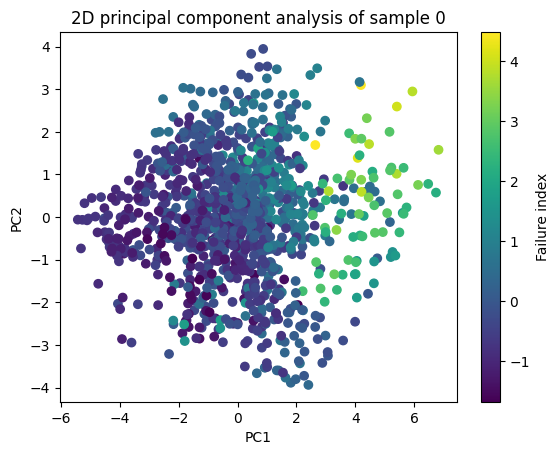

In [15]:
fig, axs = plt.subplots()
CS = plt.scatter(x = princComponents[:,0],y = princComponents[:,1], c=samples[0,:,10])
plt.title('2D principal component analysis of sample 0')
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.colorbar(CS, label = 'Failure index')


In [16]:
# 3D PCA example

pca = PCA(n_components=3) # number of components is maximum the dimensionality of the data
princComponents = pca.fit_transform(features)

# creating figure
# fig = plt.figure()
# ax = Axes3D(fig)
# fig = plt.figure()
# ax = plt.axes(projection='3d')

# # creating the plot
# plot_geeks = ax.scatter(princComponents[:,0], princComponents[:,1], princComponents[:,2], color='green')
# # setting title and labels
# ax.set_title("3D plot")
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')

# # displaying the plot
# plt.show()

marker_data = go.Scatter3d(
    x=princComponents[:,0],
    y=princComponents[:,1],
    z=princComponents[:,2],
    marker=go.scatter3d.Marker(size=3, showscale=True),
    marker_color=samples[0,:,10],
    opacity=0.8,
    mode='markers'
)


fig=go.Figure(data=marker_data)
fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

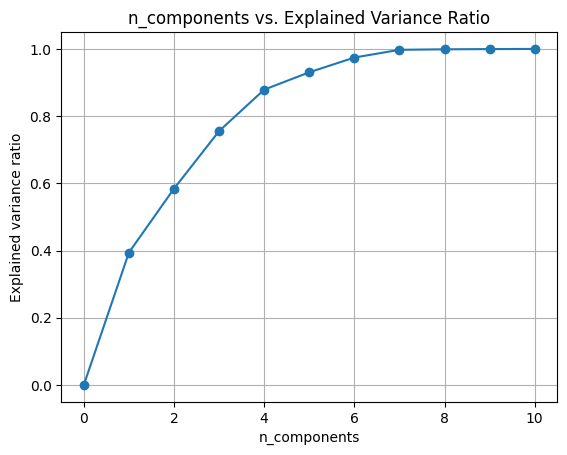

In [20]:
# Check how many principal components we need to capture the variance in the data well

nums = np.arange(11)
var_ratio = []
for num in nums:
  pcatest = PCA(n_components=num)
  pcatest.fit(samples[0,:,3:])
  var_ratio.append(np.sum(pcatest.explained_variance_ratio_))

plt.figure()
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

# CNN

In [156]:
batchSize = 8 # We have 100 images
trainValRatio = 0.90

# TO allow reproduction of results
seed = 0
# tf.random.set_seed(SEED)

# Reminder: the header index is the following
# [   0        1         2       3     4     5     6     7     8      9      10   11    12    13  ]
# ['label' 'x_coord' 'y_coord' 'e11' 'e22' 'e12' 'S11' 'S22' 'S12' 'SMises' 'FI' 'E11' 'E22' 'E12']


train_ds = samples2D[:,:,:,[11,12,13,4]] # For first experiment take stiffness matrix and attempt to predict vertical strain
X = train_ds[:,:,:,[0,1,2]]
y = train_ds[:,:,:,3]

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, train_size=trainValRatio)

epochs = 30
steps_per_epoch = len(X_train) // batchSize

In [158]:
def TBDCNet_model(inputShape, outputShape):
  input = tf.keras.layers.Input(shape=inputShape) # Shape (55, 20, 3)
  x = input

  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3),activation='relu', data_format='channels_last', padding='same') (x)
  # x = tf.keras.layers.MaxPooling2D((2, 2), strides=2)(x)
  x = tf.keras.layers.Conv2D(filters = 64, kernel_size=(3, 3),activation='relu', data_format='channels_last', padding='same') (x)
  # x = tf.keras.layers.MaxPooling2D((2, 2), strides=2)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3,  padding='same')(x)
  x = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = 3,  padding='same')(x)
  output = x



  return tf.keras.Model(inputs=input, outputs=output)




In [159]:
tf.keras.backend.clear_session() # Clear the state and frees up memory

model = TBDCNet_model(inputShape = X_train.shape[1:], outputShape = y_train.shape[1:])


model.compile(optimizer=tf.keras.optimizers.RMSprop(), # Compile
              loss='MeanSquaredError', #custom_sigmoid_focal_crossentropy,custom_SparseCategoricalCrossentropy
              metrics=['accuracy'])
modelname = 'testModel1'


In [160]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 55, 20, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 20, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 20, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 55, 20, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 55, 20, 32)        18464     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 55, 20, 1)         289   

3/3 [==============================] - 0s 58ms/step


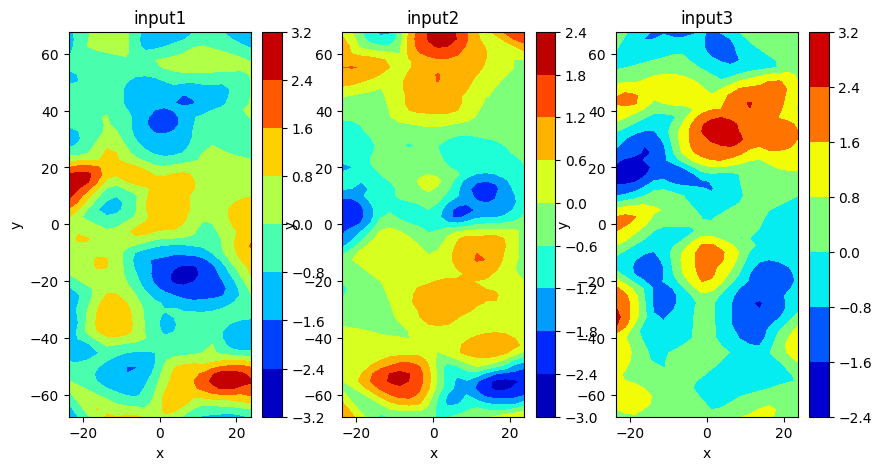

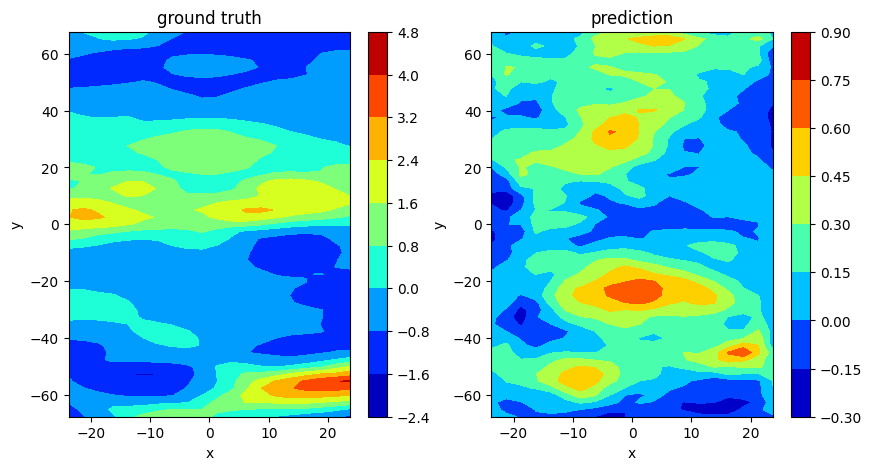

In [161]:
prediction = model.predict(X_train)[0].reshape(55,20)
grid = np.array([samples2D[0,:,:,1],samples2D[0,:,:,2]])

show_prediction(sample = X_train[0], prediction = prediction, ground_truth = y_train[0], grid = grid)

In [109]:
# Load tensorboard widget
%tensorboard --logdir logs/fit


In [162]:
model_history = model.fit(x = train_ds[:,:,:,[0,1,2]], y = train_ds[:,:,:,3],
                          epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_split=0.1,
                          )


Epoch 1/30
11/11 [==============================] - 2s 89ms/step - loss: 2.3854 - accuracy: 0.0000e+00 - val_loss: 0.6726 - val_accuracy: 0.0000e+00
Epoch 2/30
11/11 [==============================] - 1s 69ms/step - loss: 0.5732 - accuracy: 0.0000e+00 - val_loss: 0.6158 - val_accuracy: 0.0000e+00
Epoch 3/30
11/11 [==============================] - 1s 72ms/step - loss: 0.4030 - accuracy: 0.0000e+00 - val_loss: 0.6444 - val_accuracy: 0.0000e+00
Epoch 4/30
11/11 [==============================] - 1s 66ms/step - loss: 0.4380 - accuracy: 0.0000e+00 - val_loss: 0.6316 - val_accuracy: 0.0000e+00
Epoch 5/30
11/11 [==============================] - 1s 66ms/step - loss: 0.3774 - accuracy: 0.0000e+00 - val_loss: 0.5718 - val_accuracy: 0.0000e+00
Epoch 6/30
11/11 [==============================] - 1s 66ms/step - loss: 0.2928 - accuracy: 0.0000e+00 - val_loss: 0.4607 - val_accuracy: 0.0000e+00
Epoch 7/30
11/11 [==============================] - 1s 70ms/step - loss: 0.2670 - accuracy: 0.0000e+00 - v

11/11 [==============================] - 0s 25ms/step - loss: 0.1599 - accuracy: 0.0000e+00 - val_loss: 0.1824 - val_accuracy: 0.0000e+00


3/3 [==============================] - 1s 128ms/step


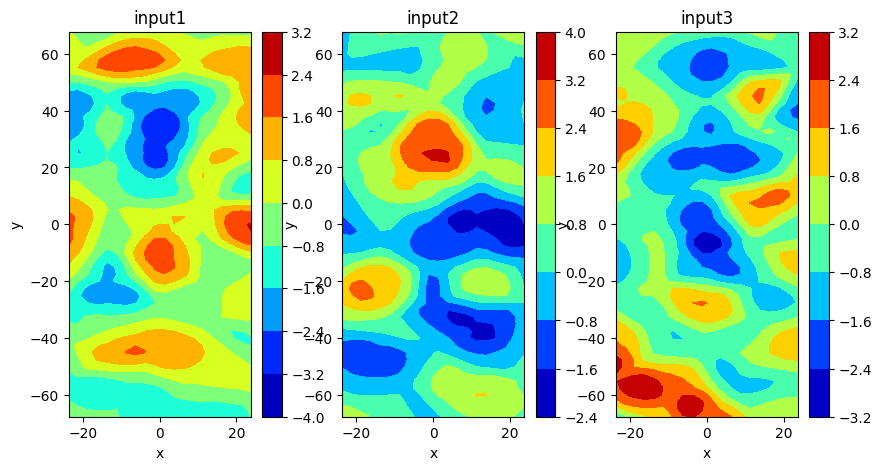

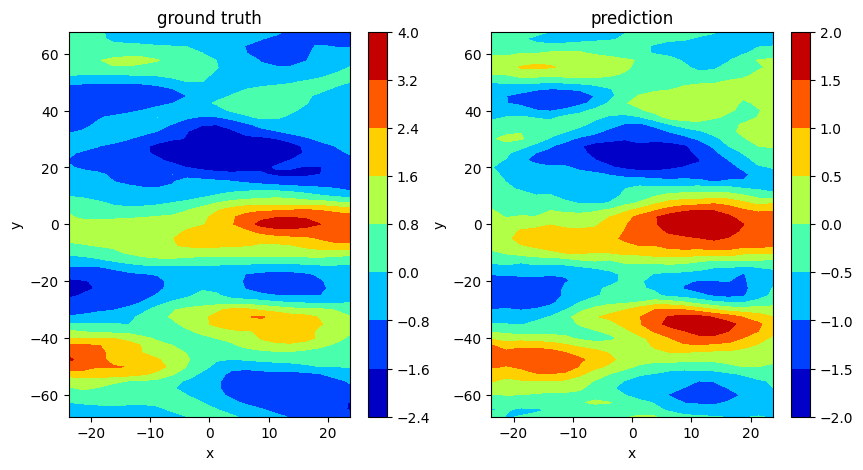

In [167]:
prediction = model.predict(X_train)[-1].reshape(55,20)
grid = np.array([samples2D[0,:,:,1],samples2D[0,:,:,2]])

show_prediction(sample = X_train[-1], prediction = prediction, ground_truth = y_train[-1], grid = grid)

In [164]:
prediction.shape

(55, 20)

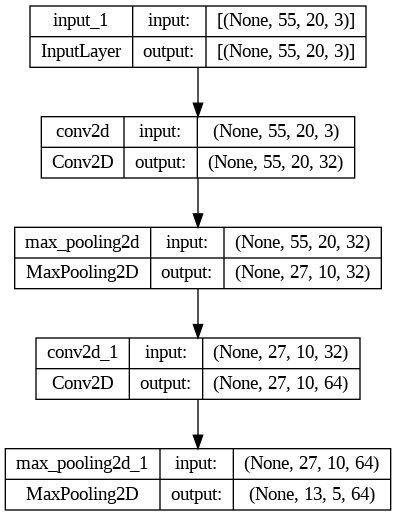

In [68]:
# Plot model to ensure connections are correct
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [47]:
train_ds.shape

(100, 55, 20, 4)